/var/folders/94/sl5fq8q56bdfmg_lqn46nhhc0000gn/T/ipykernel_44967/1664168760.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][(signals['short_mavg'] > signals['long_mavg']) & (signals['rsi'] < rsi_overbought)] = 1  # Lon

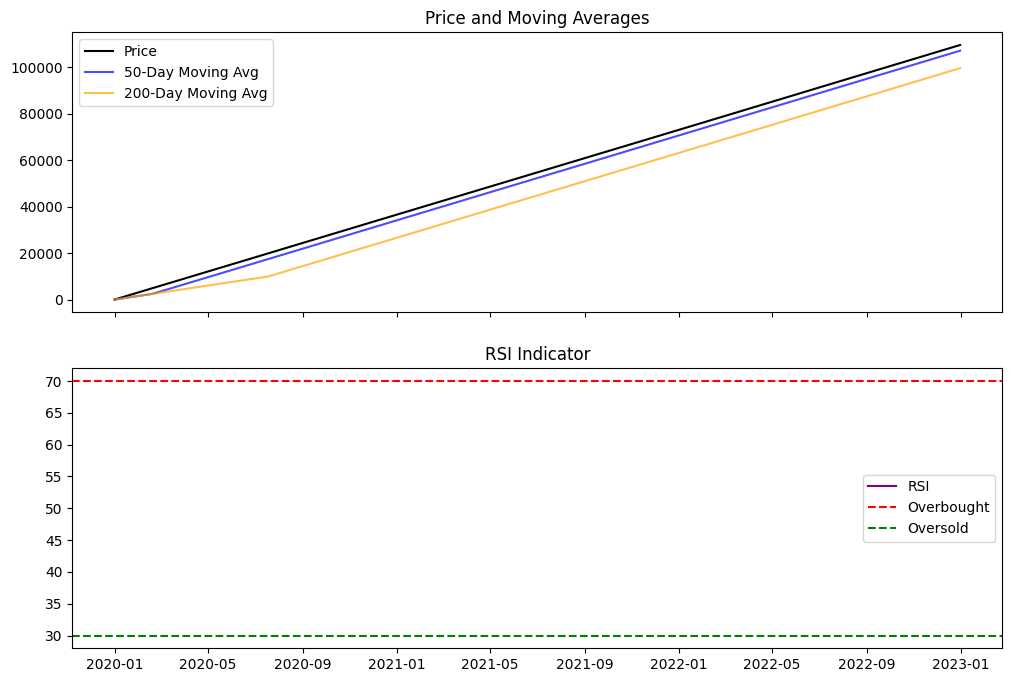

Final Portfolio Value: 10000.00
                    price     short_mavg     long_mavg  rsi  signal  \
2022-12-27  109269.149495  106817.084031  99300.983328  NaN       0   
2022-12-28  109370.604754  106917.172740  99401.206579  NaN       0   
2022-12-29  109470.708646  107017.265067  99501.418656  NaN       0   
2022-12-30  109572.173926  107117.393604  99601.624237  NaN       0   
2022-12-31  109672.012493  107217.483567  99701.822525  NaN       0   

            positions  daily_returns  portfolio_returns  cumulative_returns  
2022-12-27        0.0       0.000915                0.0             10000.0  
2022-12-28        0.0       0.000928                0.0             10000.0  
2022-12-29        0.0       0.000915                0.0             10000.0  
2022-12-30        0.0       0.000927                0.0             10000.0  
2022-12-31        0.0       0.000911                0.0             10000.0  


/var/folders/94/sl5fq8q56bdfmg_lqn46nhhc0000gn/T/ipykernel_44967/1664168760.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Final Portfolio Value: {signals['cumulative_returns'][-1]:.2f}")


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated Strategy Settings
def backtest_strategy(prices, short_window=50, long_window=200, rsi_period=14, rsi_overbought=70, rsi_oversold=30):
    # Create signals
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    
    # Moving averages for trend following (used for long/short decision)
    signals['short_mavg'] = prices.rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = prices.rolling(window=long_window, min_periods=1).mean()
    
    # RSI calculation
    delta = prices.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    signals['rsi'] = 100 - (100 / (1 + rs))
    
    # Generate long/short signals based on moving average crossover and RSI
    signals['signal'] = 0  # Default no action
    
    # Buy signal (go long): Short moving average crosses above long moving average and RSI not overbought
    signals['signal'][(signals['short_mavg'] > signals['long_mavg']) & (signals['rsi'] < rsi_overbought)] = 1  # Long
    
    # Sell signal (go short): Short moving average crosses below long moving average and RSI not oversold
    signals['signal'][(signals['short_mavg'] < signals['long_mavg']) & (signals['rsi'] > rsi_oversold)] = -1  # Short

    # Shift signal by 1 to represent decision made at the end of the day for next day
    signals['positions'] = signals['signal'].shift()
    
    # Return the strategy and signals
    return signals

# Simulate P&L from signals
def simulate_trades(signals, initial_capital=10000):
    # Calculate daily returns
    signals['daily_returns'] = signals['price'].pct_change()
    
    # Apply positions to calculate portfolio value
    signals['portfolio_returns'] = signals['daily_returns'] * signals['positions']
    
    # Calculate cumulative returns
    signals['cumulative_returns'] = (1 + signals['portfolio_returns']).cumprod() * initial_capital
    
    return signals

# Plotting the signals with cumulative returns
def plot_strategy(signals):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Price and moving averages
    ax1.plot(signals.index, signals['price'], label='Price', color='black')
    ax1.plot(signals.index, signals['short_mavg'], label='50-Day Moving Avg', color='blue', alpha=0.7)
    ax1.plot(signals.index, signals['long_mavg'], label='200-Day Moving Avg', color='orange', alpha=0.7)
    ax1.set_title('Price and Moving Averages')
    ax1.legend()

    # RSI Indicator
    ax2.plot(signals.index, signals['rsi'], label='RSI', color='purple')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold')
    ax2.set_title('RSI Indicator')
    ax2.legend()
    
    plt.show()

# Example usage with simulated price data
if __name__ == "__main__":
    # Simulated price data (you can replace this with real historical data)
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', '2022-12-31')
    prices = pd.Series(np.random.normal(100, 2, len(dates)).cumsum(), index=dates)

    # Backtest and simulate strategy
    signals = backtest_strategy(prices)
    signals = simulate_trades(signals)

    # Plot results
    plot_strategy(signals)
    
    # Show final portfolio value and cumulative returns
    print(f"Final Portfolio Value: {signals['cumulative_returns'][-1]:.2f}")
    print(signals.tail())


In [3]:
import numpy as np
import pandas as pd

def calculate_sharpe_ratio(returns, risk_free_rate=0.01, periods_per_year=252):
    """
    Calculate the Sharpe Ratio of a strategy based on returns.

    Parameters:
    - returns: A pandas Series of daily returns (or returns at any other interval).
    - risk_free_rate: The annual risk-free rate as a decimal (e.g., 0.01 for 1%).
    - periods_per_year: The number of periods per year (e.g., 252 for daily returns).

    Returns:
    - sharpe_ratio: The Sharpe Ratio of the strategy.
    """
    # Ensure the input is a pandas Series for compatibility
    if not isinstance(returns, pd.Series):
        raise ValueError("Returns should be a pandas Series.")

    # Calculate the average excess return (annualized)
    average_return = returns.mean() * periods_per_year
    
    # Annualize the risk-free rate (per period)
    annualized_rf = risk_free_rate / periods_per_year
    
    # Calculate the excess returns
    excess_returns = average_return - annualized_rf
    
    # Calculate the standard deviation of returns (annualized)
    std_dev = returns.std(ddof=0) * np.sqrt(periods_per_year)
    
    # Calculate the Sharpe Ratio
    sharpe_ratio = excess_returns / std_dev
    
    return sharpe_ratio

# Example usage
# Assume `daily_returns` is a pandas Series of daily returns from a strategy
daily_returns = pd.Series([0.001, 0.002, -0.001, 0.004, -0.003, 0.002, -0.001])
sharpe_ratio = calculate_sharpe_ratio(daily_returns)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: 4.13


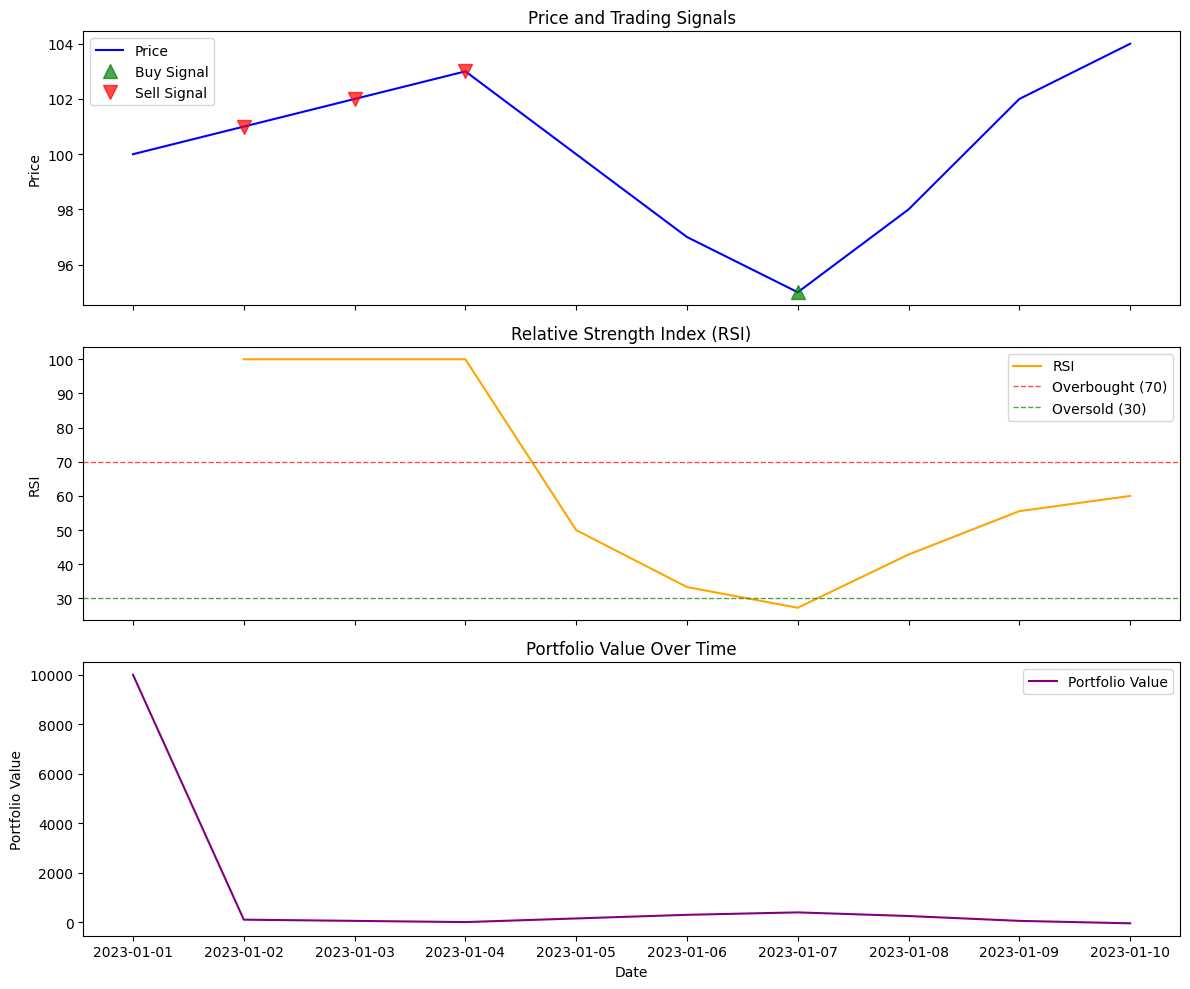

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def backtest_strategy(prices, rsi_period=14, overbought=70, oversold=30, initial_capital=10000, risk_per_trade=0.01):
    """
    Backtest an RSI-based long/short strategy.

    Parameters:
    - prices: A pandas Series of historical prices.
    - rsi_period: The period to calculate the RSI.
    - overbought: RSI value above which a short position is taken.
    - oversold: RSI value below which a long position is taken.
    - initial_capital: The initial amount of capital for the strategy.
    - risk_per_trade: The maximum risk per trade as a percentage of total capital.

    Returns:
    - results: A DataFrame containing signals, positions, and portfolio value over time.
    """

    # Create a DataFrame to hold the prices and calculated RSI values
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices

    # Calculate the RSI
    delta = prices.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    signals['rsi'] = 100 - (100 / (1 + rs))

    # Define the signals based on RSI values
    signals['long_signal'] = (signals['rsi'] < oversold).astype(int)
    signals['short_signal'] = (signals['rsi'] > overbought).astype(int)
    
    # Initialize the columns for the backtest
    signals['position'] = 0
    signals['capital'] = initial_capital
    signals['holdings'] = 0
    signals['cash'] = initial_capital
    signals['total_value'] = initial_capital
    
    # Variable to track the number of units held
    units_held = 0

    # Simulate trades based on the signals
    for i in range(1, len(signals)):
        price = signals['price'].iloc[i]
        prev_position = signals['position'].iloc[i - 1]

        # Check for long signal
        if signals['long_signal'].iloc[i] == 1 and prev_position == 0:
            stop_loss_level = price * 0.98
            position_size = calculate_position_size(price, stop_loss_level, signals['cash'].iloc[i - 1], risk_per_trade)

            units_held = position_size
            signals.at[signals.index[i], 'position'] = 1
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1] - (units_held * price)

        # Check for short signal
        elif signals['short_signal'].iloc[i] == 1 and prev_position == 0:
            stop_loss_level = price * 1.02
            position_size = calculate_position_size(price, stop_loss_level, signals['cash'].iloc[i - 1], risk_per_trade)

            units_held = -position_size
            signals.at[signals.index[i], 'position'] = -1
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1] - abs(units_held * price)

        # If already holding a position, update the portfolio value
        else:
            signals.at[signals.index[i], 'position'] = prev_position
            signals.at[signals.index[i], 'holdings'] = units_held * price
            signals.at[signals.index[i], 'cash'] = signals['cash'].iloc[i - 1]

        # Calculate the total portfolio value
        signals.at[signals.index[i], 'total_value'] = signals['holdings'].iloc[i] + signals['cash'].iloc[i]

    return signals

def calculate_position_size(price, stop_loss_level, available_cash, risk_per_trade):
    """
    Calculate the number of units to buy or short based on risk per trade.

    Parameters:
    - price: The price at which the asset is being bought or sold.
    - stop_loss_level: The stop-loss price level.
    - available_cash: The cash available for trading.
    - risk_per_trade: The maximum risk per trade as a percentage of total capital.

    Returns:
    - position_size: The number of units to buy or sell based on the risk.
    """
    risk_per_unit = abs(price - stop_loss_level)
    risk_amount = available_cash * risk_per_trade
    position_size = risk_amount // risk_per_unit if risk_per_unit > 0 else 0

    return int(position_size)

def plot_strategy(results):
    """
    Plot the trading strategy results including price, RSI, and portfolio value.

    Parameters:
    - results: A DataFrame containing the price, RSI, signals, and portfolio value from the backtest.
    """
    # Set up the figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Plot the price and signals on the first subplot
    ax1.plot(results.index, results['price'], label='Price', color='blue')
    ax1.set_ylabel('Price')
    ax1.set_title('Price and Trading Signals')

    # Plot buy and sell signals
    buy_signals = results[results['long_signal'] == 1]
    sell_signals = results[results['short_signal'] == 1]

    ax1.plot(buy_signals.index, buy_signals['price'], '^', markersize=10, color='green', label='Buy Signal', alpha=0.7)
    ax1.plot(sell_signals.index, sell_signals['price'], 'v', markersize=10, color='red', label='Sell Signal', alpha=0.7)

    ax1.legend()

    # Plot the RSI on the second subplot
    ax2.plot(results.index, results['rsi'], label='RSI', color='orange')
    ax2.axhline(y=70, color='red', linestyle='--', linewidth=1, label='Overbought (70)', alpha=0.7)
    ax2.axhline(y=30, color='green', linestyle='--', linewidth=1, label='Oversold (30)', alpha=0.7)
    ax2.set_ylabel('RSI')
    ax2.set_title('Relative Strength Index (RSI)')
    ax2.legend()

    # Plot the portfolio value on the third subplot
    ax3.plot(results.index, results['total_value'], label='Portfolio Value', color='purple')
    ax3.set_ylabel('Portfolio Value')
    ax3.set_xlabel('Date')
    ax3.set_title('Portfolio Value Over Time')
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Example price data (e.g., daily prices)
price_data = pd.Series([100, 101, 102, 103, 100, 97, 95, 98, 102, 104], 
                       index=pd.date_range(start='2023-01-01', periods=10, freq='D'))

# Run the backtest
results = backtest_strategy(price_data)

# Plot the strategy
plot_strategy(results)


# Dev Zone

In [2]:
import pandas as pd
import numpy as np
import panel as pn
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from datetime import datetime

pn.extension('plotly')

# utlis function
def keep_first_signal(signal_list):
    result = []
    in_sequence = False  # A flag to track if we are in a sequence of ones
    
    for value in signal_list:
        if value == 1:
            if not in_sequence:
                result.append(1)
                in_sequence = True
            else:
                result.append(0)
        else:
            result.append(0)
            in_sequence = False
            
    return result

class DataLoader:
    def __init__(self, csv_file: str = None, data: pd.DataFrame = None, min_date : str = None, max_date : str = None):
        """
        Initialize the DataLoader object to load and preprocess data.

        Parameters:
        - csv_file: Path to a CSV file (formatted like Yahoo Finance data).
        - data: A pandas DataFrame with historical price data.
        """
        if csv_file:
            self.data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
            self.data = self.data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        elif data is not None:
            self.data = data
        else:
            raise ValueError("Either 'data' DataFrame or 'csv_file' must be provided.")

        if min_date is not None:
            self.data = self.data[self.data.index >= min_date]
        else:
            pass
        
        if max_date is not None:
            self.data = self.data[self.data.index <= max_date]
        else :
            pass


    def get_data(self) -> pd.DataFrame:
        """
        Return the loaded data.
        """
        return self.data


class Strategy:
    def __init__(self, data: pd.DataFrame):
        """
        Initialize the Strategy class with data.

        Parameters:
        - data: A pandas DataFrame containing historical price data.
        """
        self.data = data.copy()
        self.indicators = self.data.copy()

    def calculate_moving_averages(self, moving_average_types: list = ['short', 'long1'], 
                                   short_window: int = 20, medium_window: int = 50, 
                                   long_window1: int = 100, long_window2: int = 200):
        """
        Calculate the specified moving averages and add them to the DataFrame.
        """
        if 'short' in moving_average_types:
            self.indicators = self.indicators.assign(short_ma=self.indicators['Adj Close'].rolling(window=short_window, min_periods=1).mean())
        if 'medium' in moving_average_types:
            self.indicators = self.indicators.assign(medium_ma=self.indicators['Adj Close'].rolling(window=medium_window, min_periods=1).mean())
        if 'long1' in moving_average_types:
            self.indicators = self.indicators.assign(long_ma1=self.indicators['Adj Close'].rolling(window=long_window1, min_periods=1).mean())
        if 'long2' in moving_average_types:
            self.indicators = self.indicators.assign(long_ma2=self.indicators['Adj Close'].rolling(window=long_window2, min_periods=1).mean())

    def calculate_rsi(self, period: int = 14):
        """
        Calculate the Relative Strength Index (RSI) and add it to the DataFrame.
        """

        delta = self.indicators['Adj Close'].diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)
        avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()
        rs = avg_gain / avg_loss
        self.indicators = self.indicators.assign(RSI=100 - (100 / (1 + rs)))

    def get_indicators(self) -> pd.DataFrame:
        """
        Return the data with indicators.
        """
        return self.indicators


class TradingStrategy:
    def __init__(self, strategy: Strategy):
        """
        Initialize the TradingStrategy class with indicators.

        Parameters:
        - indicators: A pandas DataFrame containing indicators calculated by the Strategy class.
        """
        self.indicators = strategy.indicators
        self.trades = None
        self.trading_instructions = pd.DataFrame({
            "date": self.indicators.index,
            "instruction" : 0
        })
        self.rsi_high = 80
        self.rsi_low = 20
        self.dca_investments = None

    def simulate_trades(self, rsi_low: int = 20, rsi_high: int = 80) -> pd.DataFrame:
        """
        Simulate trades based on RSI and moving average signals and calculate performance metrics.
        Signals are generated only when the moving average crosses over or under another.
        
        Parameters:
        - rsi_low: RSI threshold for oversold (long entry).
        - rsi_high: RSI threshold for overbought (short entry).
        """
        #self.indicators['long_signal'] = 0
        #self.indicators['short_signal'] = 0

        if rsi_low is None:
            rsi_low = self.rsi_low
        else:
            self.rsi_low = rsi_low

        if rsi_high is None:
            rsi_high = self.rsi_high
        else:
            self.rsi_high = rsi_high
        
        #for i in range(1, len(self.indicators)):
            # Buy signal when RSI < rsi_low and short_ma crosses above medium_ma (if available)
            #if (self.indicators['RSI'].iloc[i] < rsi_low #and 
                #self.indicators['short_ma'].iloc[i] > self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i] and 
                #self.indicators['short_ma'].iloc[i - 1] <= self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i - 1]
            #    ):
            #    self.indicators['long_signal'].iloc[i] = 1
                
        self.indicators = self.indicators.assign(
            long_signal=keep_first_signal(np.where(self.indicators['RSI'] < rsi_low, 1, 0))
        )

            

        # Sell signal when RSI > rsi_high and short_ma crosses below medium_ma (if available)
        #if (self.indicators['RSI'].iloc[i] > rsi_high #and 
            #self.indicators['short_ma'].iloc[i] < self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i] and 
            #self.indicators['short_ma'].iloc[i - 1] >= self.indicators.get('medium_ma', self.indicators['short_ma']).iloc[i - 1]
        #    ):
            
        #    self.indicators['short_signal'].iloc[i] = 1

        self.indicators = self.indicators.assign(
            short_signal=keep_first_signal(np.where(self.indicators['RSI'] > rsi_high, 1, 0))
        )
        
        # Define position based on the signal
        self.indicators = self.indicators.assign(
            position=np.where(self.indicators['long_signal'] == 1, 1,
                            np.where(self.indicators['short_signal'] == 1, -1, 0))
        )
        self.indicators['position'] = self.indicators['position'].shift().fillna(0)

        # Calculate daily returns
        self.indicators = self.indicators.assign(daily_return=self.indicators['Adj Close'].pct_change())
        self.indicators = self.indicators.assign(strategy_return=self.indicators['daily_return'] * self.indicators['position'])

        # Calculate cumulative returns
        self.indicators = self.indicators.assign(cumulative_return=(1 + self.indicators['strategy_return']).cumprod())

        self.trades = self.indicators
        return self.trades
    
    def generate_trading_instructions(self):
        self.trading_instructions = self.trading_instructions.assign(
            date=np.where(self.indicators['short_signal'] == 1, self.indicators.index,
                          np.where(self.indicators['long_signal'] == 1, self.indicators.index, np.datetime64('NaT')))
        )
        self.trading_instructions = self.trading_instructions.assign(
            instruction=np.where(self.indicators['short_signal'] == 1, "Short position advised",
                          np.where(self.indicators['long_signal'] == 1, "Long Position advised", 0))
        )

        return self.trading_instructions

    def get_trades(self) -> pd.DataFrame:
        """
        Return the data with indicators.
        """
        return self.trades

    def plot_strategy(self):
        """
        Plot the trading strategy performance using Plotly. It returns two graphs:
        - Price and signals graph
        - RSI and overbought/oversold levels graph
        """
        if self.trades is None:
            raise ValueError("No trades simulated. Run simulate_trades() first.")

        # First graph: Price, signals, and moving averages
        fig1 = go.Figure()

        # Plot adjusted close price
        fig1.add_trace(go.Scatter(
            x=self.trades.index, 
            y=self.trades['Adj Close'], 
            mode='lines', 
            name='Adjusted Close Price', 
            line=dict(color='blue', width=2)
        ))

        # Plot buy and sell signals
        long_signals = self.trades[self.trades['long_signal'] == 1]
        short_signals = self.trades[self.trades['short_signal'] == 1]

        fig1.add_trace(go.Scatter(
            x=long_signals.index, 
            y=long_signals['Adj Close'], 
            mode='markers', 
            name='Buy Signal', 
            marker=dict(symbol='triangle-up', color='green', size=10)
        ))

        fig1.add_trace(go.Scatter(
            x=short_signals.index, 
            y=short_signals['Adj Close'], 
            mode='markers', 
            name='Sell Signal', 
            marker=dict(symbol='triangle-down', color='red', size=10)
        ))

        # Plot moving averages if available
        for ma_col in ['short_ma', 'medium_ma', 'long_ma1', 'long_ma2']:
            if ma_col in self.trades.columns:
                fig1.add_trace(go.Scatter(
                    x=self.trades.index, 
                    y=self.trades[ma_col], 
                    mode='lines', 
                    name=ma_col, 
                    line=dict(dash='dash')
                ))

        fig1.add_trace(go.Scatter(
            x=self.indicators.index,
            y=self.indicators['cumulative_return'],
            mode='lines',
            name='Cumulative Strategy Return',
            line=dict(color='green', width=2, dash='dash')
        ))

        fig1.update_layout(
            title='Trading Strategy Performance',
            xaxis_title='Date',
            yaxis_title='Price',
            template='plotly_white'
        )

        # Second graph: RSI and oversold/overbought levels
        fig2 = go.Figure()

        fig2.add_trace(go.Scatter(
            x=self.trades.index,
            y=self.trades['RSI'],
            mode='lines',
            name='RSI',
            line=dict(color='purple', width=2)
        ))

        fig2.add_shape(type='line', x0=self.trades.index.min(), y0=self.rsi_high, x1=self.trades.index.max(), y1=self.rsi_high,
                       line=dict(color='red', dash='dash'))
        fig2.add_shape(type='line', x0=self.trades.index.min(), y0=self.rsi_low, x1=self.trades.index.max(), y1=self.rsi_low,
                       line=dict(color='green', dash='dash'))

        fig2.update_layout(
            title='RSI and Overbought/Oversold Levels',
            xaxis_title='Date',
            yaxis_title='RSI',
            template='plotly_white'
        )

        # Show both graphs
        fig1.show()
        fig2.show()
        return fig1, fig2

    def simulate_dca(self, monthly_amount: float = 1000.0) -> pd.DataFrame:
        """
        Simulate a Dollar Cost Averaging (DCA) strategy where a fixed amount is invested every month.

        Parameters:
        - monthly_amount: The fixed amount to invest at the start of each month.
        """
        # Ensure the data is sorted by date
        self.indicators = self.indicators.sort_index()

        # Create columns to store the DCA positions and value over time
        self.indicators['DCA_Units'] = 0.0
        self.indicators['DCA_Total_Investment'] = 0.0
        self.indicators['DCA_Portfolio_Value'] = 0.0

        # Track total units purchased and total investment
        total_units = 0.0
        total_investment = 0.0

        # Iterate over each row (each trading day)
        for i in range(len(self.indicators)):
            date = self.indicators.index[i]
            price = self.indicators['Adj Close'].iloc[i]

            # Check if it's the first trading day of the month
            if i == 0 or date.month != self.indicators.index[i - 1].month:
                # Calculate the units bought with the fixed amount
                units_bought = monthly_amount / price
                total_units += units_bought
                total_investment += monthly_amount

            # Update the columns with the current DCA stats
            self.indicators.at[date, 'DCA_Units'] = total_units
            self.indicators.at[date, 'DCA_Total_Investment'] = total_investment
            self.indicators.at[date, 'DCA_Portfolio_Value'] = total_units * price

        self.dca_investments = self.indicators
        return self.dca_investments

    def plot_dca_strategy(self):
        """
        Plot the DCA strategy performance using Plotly. It shows:
        - Adjusted Close price over time.
        - Portfolio value over time using the DCA strategy.
        - Total investment over time using the DCA strategy.
        """
        if self.dca_investments is None:
            raise ValueError("No DCA investments simulated. Run simulate_dca() first.")

        fig = go.Figure()

        # Plot adjusted close price
        fig.add_trace(go.Scatter(
            x=self.dca_investments.index, 
            y=self.dca_investments['Adj Close'], 
            mode='lines', 
            name='Adjusted Close Price', 
            line=dict(color='blue', width=2)
        ))

        # Plot total investment
        fig.add_trace(go.Scatter(
            x=self.dca_investments.index, 
            y=self.dca_investments['DCA_Total_Investment'], 
            mode='lines', 
            name='Total Investment', 
            line=dict(color='orange', width=2, dash='dash')
        ))

        # Plot DCA portfolio value
        fig.add_trace(go.Scatter(
            x=self.dca_investments.index, 
            y=self.dca_investments['DCA_Portfolio_Value'], 
            mode='lines', 
            name='DCA Portfolio Value', 
            line=dict(color='green', width=2)
        ))

        fig.update_layout(
            title='DCA Strategy Performance',
            xaxis_title='Date',
            yaxis_title='Value (EUR)',
            template='plotly_white'
        )

        fig.show()
        return fig
    
    def plot_combined_strategy(self) -> go.Figure:
        """
        Create a combined plot for trading strategy performance, RSI levels, and DCA.

        Returns:
        - A Plotly figure object.
        """
        # Create a subplot grid for the combined figure
        fig = make_subplots(
            rows=3, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.05,
            subplot_titles=("Trading Strategy Performance", "RSI & Overbought/Oversold Levels", "DCA Strategy Performance"),
            row_heights=[0.4, 0.3, 0.3]
        )

        # Trading strategy performance
        fig.add_trace(go.Scatter(
            x=self.indicators.index,
            y=self.indicators['Adj Close'],
            mode='lines',
            name='Adjusted Close Price',
            line=dict(color='blue', width=2)
        ), row=1, col=1)

        fig.add_trace(go.Scatter(
            x=self.indicators.index,
            y=self.indicators['cumulative_return'],
            mode='lines',
            name='Cumulative Strategy Return',
            line=dict(color='green', width=2, dash='dash')
        ), row=1, col=1)

        # RSI and Overbought/Oversold levels
        fig.add_trace(go.Scatter(
            x=self.indicators.index,
            y=self.indicators['RSI'],
            mode='lines',
            name='RSI',
            line=dict(color='purple', width=2)
        ), row=2, col=1)

        fig.add_trace(go.Scatter(
            x=self.indicators.index,
            y=[80] * len(self.indicators),
            mode='lines',
            name='Overbought Level (80)',
            line=dict(color='red', width=1, dash='dot')
        ), row=2, col=1)

        fig.add_trace(go.Scatter(
            x=self.indicators.index,
            y=[20] * len(self.indicators),
            mode='lines',
            name='Oversold Level (20)',
            line=dict(color='green', width=1, dash='dot')
        ), row=2, col=1)

        # DCA Strategy performance
        if self.dca_investments is not None:
            fig.add_trace(go.Scatter(
                x=self.dca_investments.index,
                y=self.dca_investments['DCA_Total_Investment'],
                mode='lines',
                name='Total Investment',
                line=dict(color='orange', width=2, dash='dash')
            ), row=3, col=1)

            fig.add_trace(go.Scatter(
                x=self.dca_investments.index,
                y=self.dca_investments['DCA_Portfolio_Value'],
                mode='lines',
                name='DCA Portfolio Value',
                line=dict(color='green', width=2)
            ), row=3, col=1)

        fig.update_layout(
            height=1000,
            title='Trading Strategy, RSI Levels, and DCA Performance',
            xaxis_title='Date',
            yaxis_title='Value (USD)',
            template='plotly_white'
        )

        return fig

    def create_table(self) -> go.Figure:
        """
        Create a table summarizing key indicators.

        Returns:
        - A Plotly figure object.
        """
        table_data = self.indicators[['Adj Close', 'RSI', 'cumulative_return']].tail(10)  # Last 10 rows for simplicity

        fig = go.Figure(data=[go.Table(
            header=dict(values=list(table_data.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[table_data[col] for col in table_data.columns],
                       fill_color='lavender',
                       align='left'))
        ])

        fig.update_layout(title="Summary Table of Indicators (Last 10 Rows)")
        return fig

    def save_html_report(self, filename: str = "trading_report.html"):
        """
        Save the combined graphs and table as an HTML file.

        Parameters:
        - filename: The name of the HTML file.
        """
        # Generate individual components
        trad_fig, rsi_fig = self.plot_strategy()
        dca_fig = self.plot_dca_strategy()
        table_fig = self.create_table()

        # Convert figures to HTML components
        strategy_html = trad_fig.to_html(full_html=False, include_plotlyjs='cdn')
        rsi_html = rsi_fig.to_html(full_html=False, include_plotlyjs=False)
        table_html = table_fig.to_html(full_html=False, include_plotlyjs=False)
        dca_html = dca_fig.to_html(full_html=False, include_plotlyjs=False)

        # Assemble the HTML file
        html_content = f"""
        <html>
        <head>
            <title>Trading Strategy Report</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
            }}
            .grid-container {{
                display: grid;
                grid-template-columns: 1fr 1fr;
                grid-gap: 20px;
                margin: 20px;
            }}
            .grid-item {{
                border: 1px solid #ddd;
                padding: 10px;
                background-color: #f9f9f9;
            }}
            h1 {{
                text-align: center;
            }}
            .plotly-graph-div {{
                width: 100%;
                height: 100%;
            }}
        </style>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    </head>
    <body>
        <h1>Trading Strategy Report</h1>
        <div class="grid-container">
            <div class="grid-item">
                <h2>Trading Strategy Performance</h2>
                <div>{strategy_html}</div>
            </div>
            <div class="grid-item">
                <h2>RSI and Overbought/Oversold Levels</h2>
                <div>{rsi_html}</div>
            </div>
            <div class="grid-item">
                <h2>DCA Strategy Performance</h2>
                <div>{dca_html}</div>
            </div>
            <div class="grid-item">
                <h2>Indicators Summary Table</h2>
                <div>{table_html}</div>
            </div>
        </div>
    </body>
    </html>
    """

        # Write the HTML content to the file
        with open(filename, "w") as f:
            f.write(html_content)
    
    def display_report(self):
        # Create individual components
        trading_fig = self.plot_trading_strategy()
        rsi_fig = self.plot_rsi()
        dca_fig = self.plot_dca_strategy()
        table_pane = self.create_table()

        # Convert Plotly figures to Panel objects
        trading_panel = pn.pane.Plotly(trading_fig, sizing_mode='stretch_both')
        rsi_panel = pn.pane.Plotly(rsi_fig, sizing_mode='stretch_both')
        dca_panel = pn.pane.Plotly(dca_fig, sizing_mode='stretch_both')

        # Arrange components in a 2x2 grid
        grid = pn.GridSpec(sizing_mode='stretch_both', max_height=800)
        grid[0, 0] = trading_panel
        grid[0, 1] = rsi_panel
        grid[1, 0] = dca_panel
        grid[1, 1] = table_pane

        # Display the grid layout
        dashboard = pn.Column(
            pn.pane.Markdown("# Trading Strategy Report"),
            grid,
            sizing_mode='stretch_both'
        )
        
        dashboard.show()

# Example usage
data_loader = DataLoader(csv_file='./ALO.PA.csv', min_date="2023-11-01")
indicators = data_loader.get_data()

strategy = Strategy(indicators)
strategy.calculate_moving_averages()
strategy.calculate_rsi()
#strategy.get_indicators()

trading_strategy = TradingStrategy(strategy)
trading_strategy.simulate_trades(rsi_low=20, rsi_high=80)
ti = trading_strategy.generate_trading_instructions()
trading_strategy.simulate_dca(50)
#fig3 = trading_strategy.plot_dca_strategy()
#fig1, fig2 = trading_strategy.plot_strategy()
trades = trading_strategy.get_trades()

trading_strategy.save_html_report()


In [3]:
trades

,Open,High,Low,Close,Adj Close,Volume,short_ma,long_ma1,RSI,long_signal,short_signal,position,daily_return,strategy_return,cumulative_return
Date,,,,,,,,,,,,,,,
2023-11-01,12.760000,12.885000,12.700000,12.750000,12.750000,1316121.0,12.75000,12.750000,NaN,0,0,0.0,NaN,NaN,NaN
2023-11-02,12.945000,13.420000,12.900000,13.210000,13.210000,2971570.0,12.98000,12.980000,100.000000,0,1,0.0,0.036078,0.000000,1.000000
2023-11-03,13.385000,14.215000,13.290000,13.895000,13.895000,3172643.0,13.28500,13.285000,100.000000,0,0,-1.0,0.051855,-0.051855,0.948145
2023-11-06,14.085000,14.155000,13.750000,13.750000,13.750000,2133113.0,13.40125,13.401250,88.759662,0,0,0.0,-0.010435,-0.000000,0.948145
2023-11-07,13.600000,13.675000,13.335000,13.575000,13.575000,1884700.0,13.43600,13.436000,78.156969,0,0,0.0,-0.012727,-0.000000,0.948145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07,19.750000,19.879999,19.469999,19.480000,19.480000,783138.0,17.90650,17.418993,76.574296,0,0,0.0,0.002573,0.000000,1.062145
2024-10-08,19.235001,19.555000,19.165001,19.405001,19.405001,688924.0,18.06275,17.441913,75.905146,0,0,0.0,-0.003850,-0.000000,1.062145
2024-10-09,19.365000,19.725000,19.330000,19.725000,19.725000,458549.0,18.24400,17.468128,73.883658,0,0,0.0,0.016491,0.000000,1.062145


In [4]:
ti.tail()

,date,instruction
237,NaT,0
238,NaT,0
239,NaT,0
240,NaT,0
241,NaT,0


In [5]:
trading_strategy.indicators

,Open,High,Low,Close,Adj Close,Volume,short_ma,long_ma1,RSI,long_signal,short_signal,position,daily_return,strategy_return,cumulative_return,DCA_Units,DCA_Total_Investment,DCA_Portfolio_Value
Date,,,,,,,,,,,,,,,,,,
2023-11-01,12.760000,12.885000,12.700000,12.750000,12.750000,1316121.0,12.75000,12.750000,NaN,0,0,0.0,NaN,NaN,NaN,3.921569,50.0,50.000000
2023-11-02,12.945000,13.420000,12.900000,13.210000,13.210000,2971570.0,12.98000,12.980000,100.000000,0,1,0.0,0.036078,0.000000,1.000000,3.921569,50.0,51.803922
2023-11-03,13.385000,14.215000,13.290000,13.895000,13.895000,3172643.0,13.28500,13.285000,100.000000,0,0,-1.0,0.051855,-0.051855,0.948145,3.921569,50.0,54.490198
2023-11-06,14.085000,14.155000,13.750000,13.750000,13.750000,2133113.0,13.40125,13.401250,88.759662,0,0,0.0,-0.010435,-0.000000,0.948145,3.921569,50.0,53.921569
2023-11-07,13.600000,13.675000,13.335000,13.575000,13.575000,1884700.0,13.43600,13.436000,78.156969,0,0,0.0,-0.012727,-0.000000,0.948145,3.921569,50.0,53.235293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07,19.750000,19.879999,19.469999,19.480000,19.480000,783138.0,17.90650,17.418993,76.574296,0,0,0.0,0.002573,0.000000,1.062145,41.589252,600.0,810.158603
2024-10-08,19.235001,19.555000,19.165001,19.405001,19.405001,688924.0,18.06275,17.441913,75.905146,0,0,0.0,-0.003850,-0.000000,1.062145,41.589252,600.0,807.039457
2024-10-09,19.365000,19.725000,19.330000,19.725000,19.725000,458549.0,18.24400,17.468128,73.883658,0,0,0.0,0.016491,0.000000,1.062145,41.589252,600.0,820.348005
